# Preprocessing the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import norm, skew


from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.metrics import *

import sys, os
import random 

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from IPython import display, utils

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,LSTM

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from scipy.io import savemat, loadmat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics, losses
from tensorflow.keras import backend as K

In [2]:
solar_wind = pd.read_csv("./input/solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

dst = pd.read_csv("./input/labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv("./input/sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

In [3]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

In [4]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [5]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4

In [6]:
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [7]:
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

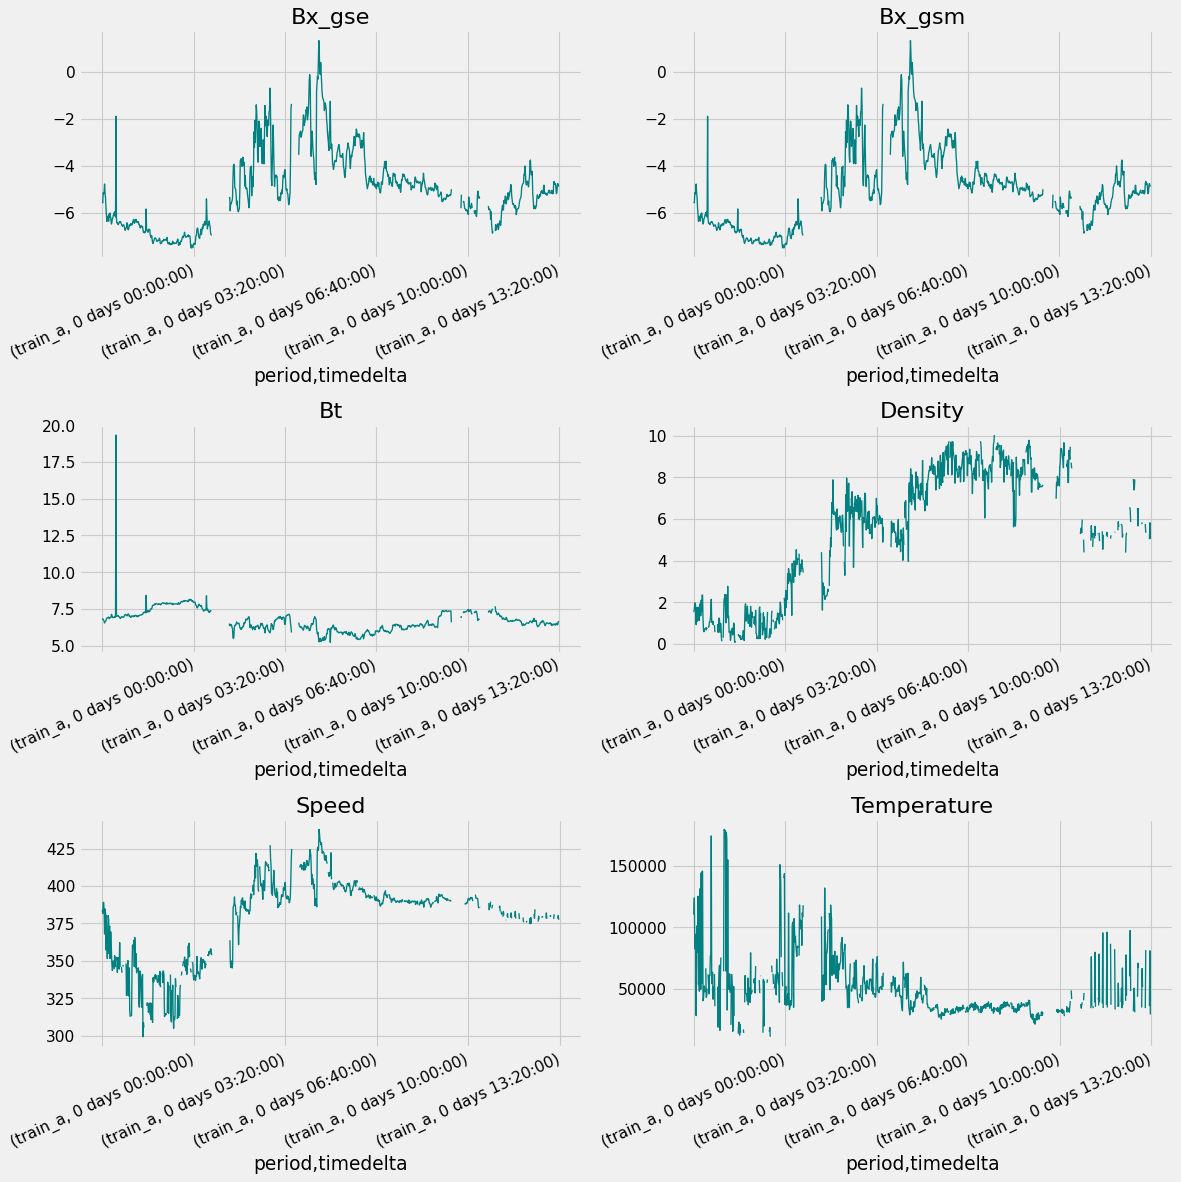

In [8]:
plt.style.use('fivethirtyeight')
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,color='teal', lw=1.2
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [9]:
solar_wind.isnull().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

<Figure size 1440x1080 with 0 Axes>

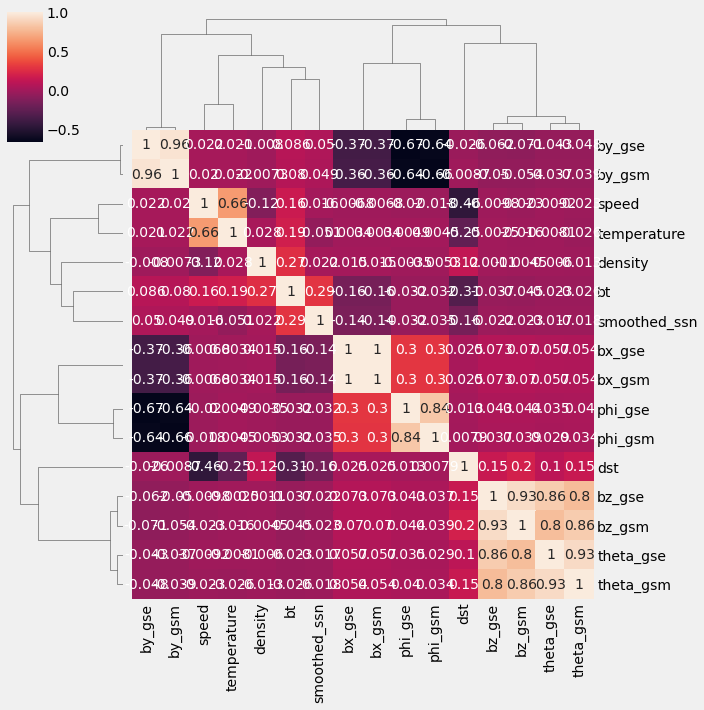

In [10]:
joined = solar_wind.join(sunspots).join(dst).fillna(method="ffill")

plt.figure(figsize=(20, 15))
sns.clustermap(joined.corr(), annot=True)

In [11]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

In [12]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [13]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [14]:
assert (features.isna().sum() == 0).all()

In [15]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

In [16]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

# Train a LSTM model with keras

## Create the model

In [17]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = data.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

In [18]:
import tensorflow as tf
from keras import preprocessing

data_config = {"timesteps": 12, "batch_size": 500}

def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 245
Number of val batches: 18


In [19]:
print(val_ds)
timeseries_dataset_from_df(test, data_config["batch_size"])


<ConcatenateDataset shapes: ((None, None, 15), (None, 2)), types: (tf.float64, tf.float64)>


<ConcatenateDataset shapes: ((None, None, 15), (None, 2)), types: (tf.float64, tf.float64)>

In [20]:
# Printing the final loss and accuracy once the training is complete        
def print_training_info(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    print('Model loss {0:g}; Val loss {1:g}'.format(loss[-1], val_loss[-1]))

In [21]:
def generate_model(batch_input_shape, output_dim, n_layer, n_hidden,
                   optimizer_meth, act_fcn, act_fcn_output, model_config, learning_rate, reg):
    model = Sequential()
    """
    input_dim:           the size of input vector
    output_dim:          the size of output vector
    n_layer:             number of hidden layers in the network
    n_hidden:            a list of number of hidden units in each hidden layer. 
                         for example, for n_hidden=3, this can be [200, 100, 45]
    optimizer_meth:      the optimization method used for training
    act_fcn              the type of activation function in the hidden layers
    act_fcn_output       the type of activation function in the output layer
    learning_rate        Learning rate used in the training phase
    reg                  L2 regularization coefficient
    """
    
    model.add(LSTM(n_hidden[0],activation='relu', 
                   batch_input_shape=batch_input_shape,
                   stateful=model_config["stateful"],
                   dropout=model_config["dropout"],
                   return_sequences=True))
    
    model.add(LSTM(n_hidden[1],activation=act_fcn))
    
    for i in range (2, n_layer):
        model.add(Dense(n_hidden[i], activation=act_fcn,
                        kernel_regularizer=tf.keras.regularizers.l2(l=reg)))
        #model.add(BatchNormalization())

        
    model.add(Dense(output_dim, activation=act_fcn_output, 
                    kernel_regularizer=tf.keras.regularizers.l2(l=reg)))
    #model.add(BatchNormalization())
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(), 
                  optimizer=optimizer_meth)
    
    #loss=tf.keras.losses.BinaryCrossentropy()
    
    model.optimizer.learning_rate.assign(learning_rate)
    
    return model

In [22]:
def train(model, train_ds, val_ds, batch_size, epochs, verbose=1):
    """
    model:       the DNN model (the output of generate_model)
    x_train:     input of the network
    y_train:     output of the network
    batch_size:  batch size parameter
    epochs:      number of epochs used to train the network
    validation_split:  validation/train split ration (this number is the fraction of data used as validation set)
    """
    
    #### ToDo:  use the training data and train your model. 
    
    history_model = model.fit(train_ds,
                              batch_size=batch_size,
                              epochs=epochs, 
                              verbose=1, 
                              shuffle=False,
                              validation_data=val_ds)
    

    #### hint: Plot the loss function for the training and validation set to observe your network performance.
    
    plt.plot(history_model.history['loss'], label='training')
    plt.plot(history_model.history['val_loss'], label='validation')
    plt.title('Training and Validation losses')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('No. epoch')
    plt.legend()
    plt.show()
    
    print(print_training_info(history_model))
    return history_model


In [23]:
model_config = {"n_epochs": 50, "dropout": 0.4, "stateful": False}


# usually set to (`batch_size`, `sequence_length`, `n_features`)
# setting the batch size to None allows for variable length batches
batch_input_shape = (None, data_config["timesteps"], len(XCOLS))
output_dim = len(YCOLS)
n_layer = 10
n_hidden = [30, 20, 20, 20, 20, 20, 20, 20, 20, 40]
optimizer_meth = Adam()
act_fcn = 'relu'
act_fcn_output = 'linear'
learning_rate = 0.0005
reg=0.005


model = generate_model(batch_input_shape, output_dim, n_layer, n_hidden, 
                       optimizer_meth, act_fcn, act_fcn_output, model_config, learning_rate, reg)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 30)            5520      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                4

Epoch 1/50
245/245 [==============================] - 6s 17ms/step - loss: 358.2813 - val_loss: 359.6301
Epoch 2/50
245/245 [==============================] - 4s 16ms/step - loss: 216.9682 - val_loss: 333.8659
Epoch 3/50
245/245 [==============================] - 4s 18ms/step - loss: 198.4174 - val_loss: 333.3736
Epoch 4/50
245/245 [==============================] - 4s 16ms/step - loss: 189.0480 - val_loss: 314.1678
Epoch 5/50
245/245 [==============================] - 4s 17ms/step - loss: 183.7708 - val_loss: 292.6229
Epoch 6/50
245/245 [==============================] - 4s 16ms/step - loss: 182.5063 - val_loss: 286.0911
Epoch 7/50
245/245 [==============================] - 4s 17ms/step - loss: 178.9302 - val_loss: 272.7993
Epoch 8/50
245/245 [==============================] - 4s 17ms/step - loss: 174.8407 - val_loss: 276.5824
Epoch 9/50
245/245 [==============================] - 4s 16ms/step - loss: 173.9690 - val_loss: 279.8587
Epoch 10/50
245/245 [==============================] - 

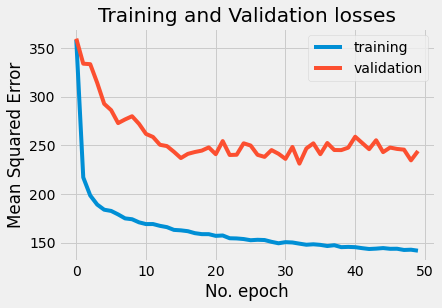

Model loss 141.643; Val loss 244.067
None


In [24]:
batch_size=data_config["batch_size"]
epochs = model_config["n_epochs"]

history = train(model, train_ds, val_ds, batch_size, epochs, verbose=1)

In [25]:
model.save("model.h5")

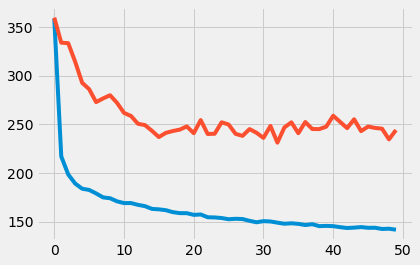

In [26]:
for name, values in history.history.items():
    plt.plot(values)

In [27]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.2f}")

36/36 [==============================] - 0s 11ms/step - loss: 215.1597
Test RMSE: 14.67


## Hyper-parameter selection

In [28]:
# hyper-parameter selection function:

def hyp_tuning(model_config, data_config, output_dim, train_ds, val_ds, batch_size, epochs, 
               learning_rate, regularization):
    """
    ToDo: find the optimal combination of learning rate and regularization coefficient.
    add more inputs to the function if necessary
    
    x_train:     input of the network
    y_train:     output of the network
    learning_rate: different values of learning rate used as hyper-parameter
    regularization: different values of regularization coefficient used as hyper-parameter
    
    opt_lr:  the optimal learning rate
    opt_reg: the optimal regularization coefficient
    """


    # usually set to (`batch_size`, `sequence_length`, `n_features`)
    # setting the batch size to None allows for variable length batches
    batch_input_shape = (None, data_config["timesteps"], len(XCOLS))
    n_layer = 10
    n_hidden = [30, 20, 20, 20, 20, 20, 20, 20, 20, 40]
    optimizer_meth = Adam()
    act_fcn = 'relu'
    act_fcn_output = 'linear'
    loss_min = 10000

    #### hint: You may need to call generate_model() and train() functions here
    for lr in learning_rate:
        for reg in regularization:
            model = generate_model(batch_input_shape, output_dim, n_layer, n_hidden, 
                       optimizer_meth, act_fcn, act_fcn_output, model_config, lr, reg)
            history_model = train(model, train_ds, val_ds, batch_size, epochs, verbose=1)
            
            val_loss = history_model.history['val_loss'][-1]
            if val_loss < loss_min:
                loss_min = val_loss
                opt_lr = lr
                opt_reg = reg
    
    return opt_lr, opt_reg

Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 466.8683 - val_loss: 559.4889
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 300.7326 - val_loss: 335.2822
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 232.8559 - val_loss: 321.0648
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 220.2025 - val_loss: 312.3896
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 212.4628 - val_loss: 307.9396


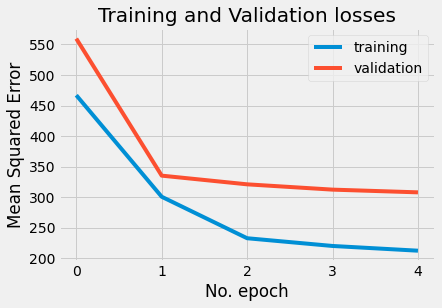

Model loss 212.463; Val loss 307.94
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 361.6588 - val_loss: 318.1358
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 253.7295 - val_loss: 293.1750
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 232.1023 - val_loss: 287.1295
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 218.6051 - val_loss: 285.3421
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 210.0930 - val_loss: 277.8743


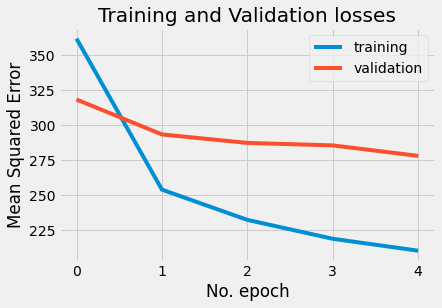

Model loss 210.093; Val loss 277.874
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 376.7878 - val_loss: 315.4192
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 248.8931 - val_loss: 306.6822
Epoch 3/5
245/245 [==============================] - 4s 17ms/step - loss: 225.9582 - val_loss: 298.1166
Epoch 4/5
245/245 [==============================] - 4s 17ms/step - loss: 218.7074 - val_loss: 288.3835
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 213.5686 - val_loss: 287.1937


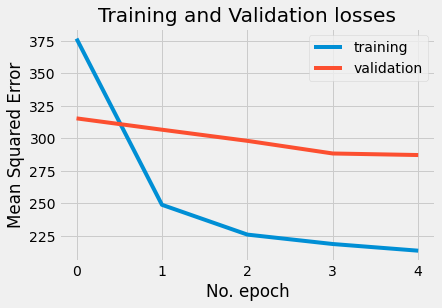

Model loss 213.569; Val loss 287.194
None
Epoch 1/5
245/245 [==============================] - 6s 16ms/step - loss: 361.8210 - val_loss: 352.5404
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 244.2364 - val_loss: 335.5425
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 228.0896 - val_loss: 332.0370
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 225.2231 - val_loss: 333.2213
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 217.4556 - val_loss: 324.8588


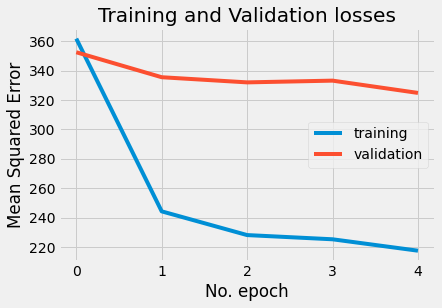

Model loss 217.456; Val loss 324.859
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 338.7953 - val_loss: 363.4291
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 228.1555 - val_loss: 352.3730
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 217.0797 - val_loss: 341.2084
Epoch 4/5
245/245 [==============================] - 4s 15ms/step - loss: 211.4384 - val_loss: 335.5944
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 204.1434 - val_loss: 322.8581


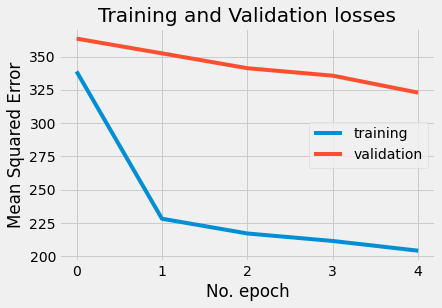

Model loss 204.143; Val loss 322.858
None
Epoch 1/5
245/245 [==============================] - 5s 16ms/step - loss: 278.8007 - val_loss: 344.5176
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 203.5811 - val_loss: 320.9092
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 200.1367 - val_loss: 314.6548
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 191.3009 - val_loss: 308.8239
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 183.8134 - val_loss: 315.1382


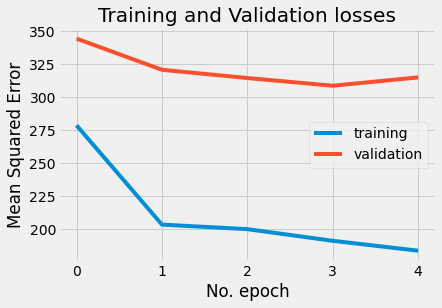

Model loss 183.813; Val loss 315.138
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 334.7733 - val_loss: 361.1761
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 218.2940 - val_loss: 358.1855
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 218.1603 - val_loss: 350.4919
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 210.1115 - val_loss: 337.1857
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 206.3482 - val_loss: 343.8346


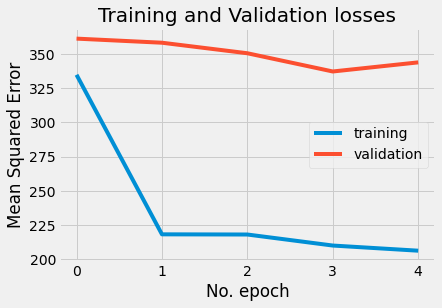

Model loss 206.348; Val loss 343.835
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 312.4509 - val_loss: 336.5306
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 228.9461 - val_loss: 336.7724
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 212.9559 - val_loss: 344.6618
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 205.5768 - val_loss: 333.6615
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 198.6301 - val_loss: 329.8500


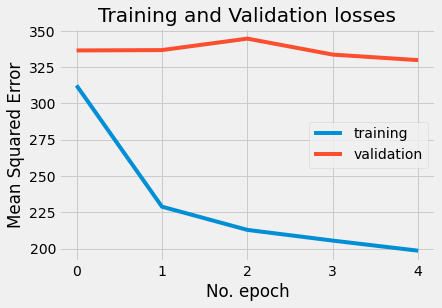

Model loss 198.63; Val loss 329.85
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 458.1635 - val_loss: 559.2930
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 360.5458 - val_loss: 543.3293
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 358.2735 - val_loss: 546.7145
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 357.5629 - val_loss: 542.0966
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 358.3606 - val_loss: 539.5176


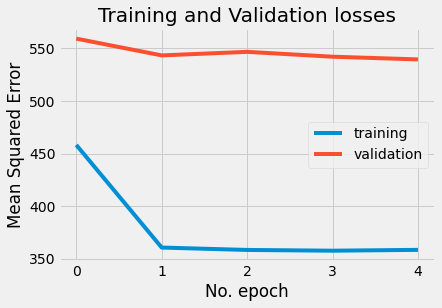

Model loss 358.361; Val loss 539.518
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 403.6013 - val_loss: 565.4205
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 362.3915 - val_loss: 554.8668
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 360.9810 - val_loss: 548.8075
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 359.9396 - val_loss: 544.4639
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 359.1144 - val_loss: 541.7123


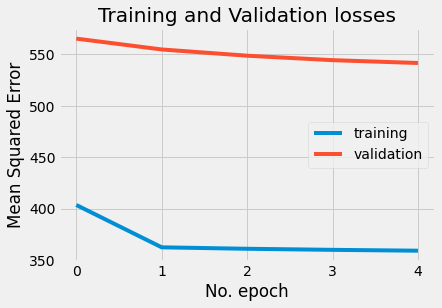

Model loss 359.114; Val loss 541.712
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 22146.0410 - val_loss: 527.7598
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 302.0130 - val_loss: 466.4670
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 268.9887 - val_loss: 487.2613
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 262.6517 - val_loss: 460.0683
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 251.1296 - val_loss: 449.3910


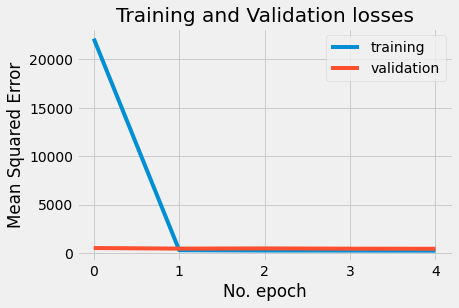

Model loss 251.13; Val loss 449.391
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 801.4769 - val_loss: 576.2255
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 385.8423 - val_loss: 542.3868
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 369.8734 - val_loss: 537.3845
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 367.0012 - val_loss: 536.5349
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 366.6729 - val_loss: 541.5640


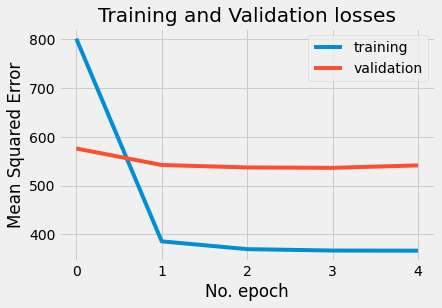

Model loss 366.673; Val loss 541.564
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: nan - val_loss: nan
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan
Epoch 3/5
245/245 [==============================] - 4s 17ms/step - loss: nan - val_loss: nan
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan


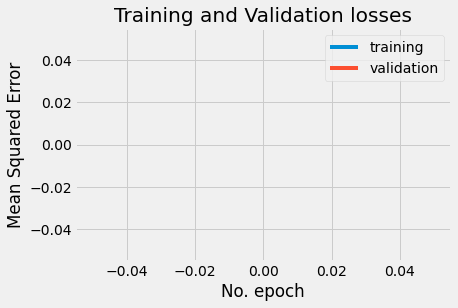

Model loss nan; Val loss nan
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 5542844810919936.0000 - val_loss: 741.8715
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 559.7868 - val_loss: 720.4550
Epoch 3/5
245/245 [==============================] - 4s 17ms/step - loss: 548.0266 - val_loss: 713.9309
Epoch 4/5
245/245 [==============================] - 4s 17ms/step - loss: 542.1227 - val_loss: 708.2948
Epoch 5/5
245/245 [==============================] - 4s 17ms/step - loss: 536.3855 - val_loss: 701.9596


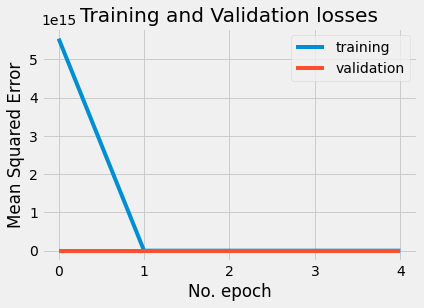

Model loss 536.385; Val loss 701.96
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: nan - val_loss: nan
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan


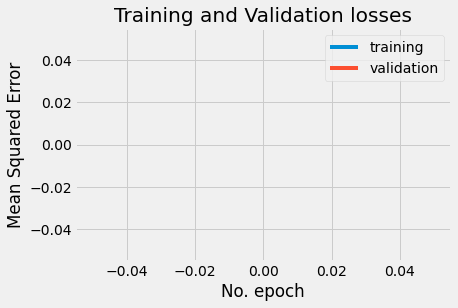

Model loss nan; Val loss nan
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: nan - val_loss: nan
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: nan - val_loss: nan


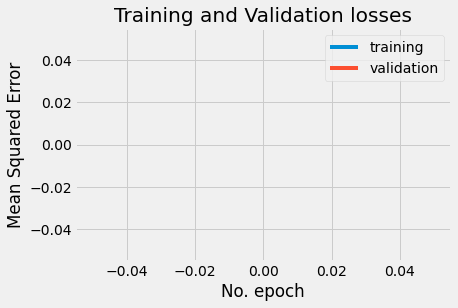

Model loss nan; Val loss nan
None


(0.0001, 0.001)

In [29]:
model_config = {"n_epochs": 5, "dropout": 0.4, "stateful": False}
output_dim = len(YCOLS)
batch_size=data_config["batch_size"]
epochs = model_config["n_epochs"]
learning_rate = [1e-4, 1e-3, 1e-2, .1]
regularization = [1e-4, 1e-3, 1e-2, .1]

        
hyp_tuning(model_config, data_config, output_dim, train_ds, val_ds, batch_size, epochs,learning_rate, regularization)

Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 460.0374 - val_loss: 537.8912
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 346.7215 - val_loss: 379.7733
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 268.4543 - val_loss: 368.1206
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 241.9582 - val_loss: 342.0779
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 230.1259 - val_loss: 321.3469


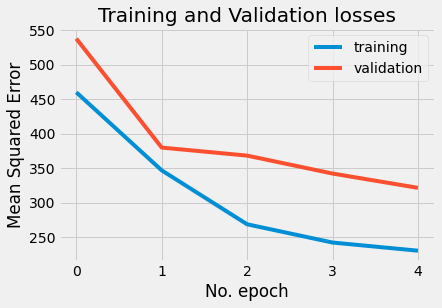

Model loss 230.126; Val loss 321.347
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 386.5595 - val_loss: 365.6922
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 274.7114 - val_loss: 332.9436
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 246.6693 - val_loss: 320.9826
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 234.2173 - val_loss: 311.6970
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 224.5154 - val_loss: 303.8640


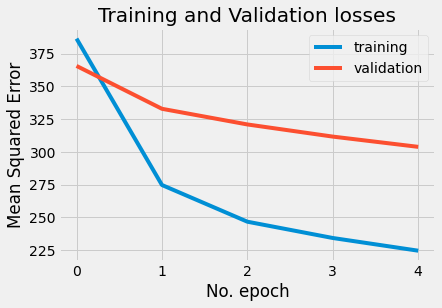

Model loss 224.515; Val loss 303.864
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 407.1833 - val_loss: 359.1501
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 251.2508 - val_loss: 314.8409
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 224.1204 - val_loss: 283.9524
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 216.5698 - val_loss: 276.2980
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 209.4044 - val_loss: 269.0735


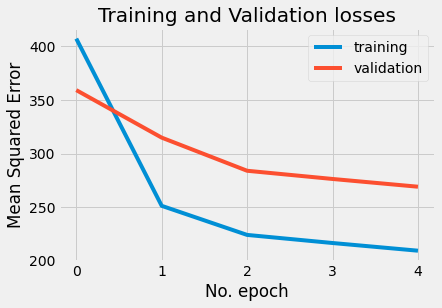

Model loss 209.404; Val loss 269.074
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 473.7178 - val_loss: 649.5854
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 472.8271 - val_loss: 647.6060
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 471.4744 - val_loss: 643.3606
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 468.2352 - val_loss: 632.4856
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 457.7156 - val_loss: 594.1426


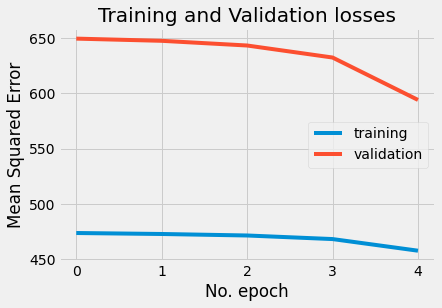

Model loss 457.716; Val loss 594.143
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 473.5858 - val_loss: 649.1894
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 472.5647 - val_loss: 647.5599
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 471.1562 - val_loss: 645.1456
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 469.0087 - val_loss: 640.5934
Epoch 5/5
245/245 [==============================] - 4s 17ms/step - loss: 465.4834 - val_loss: 632.1230


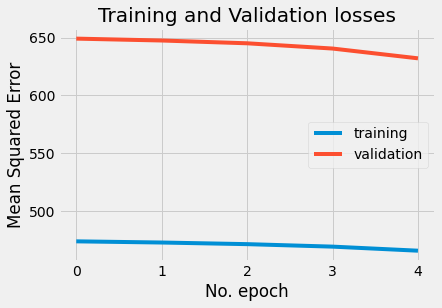

Model loss 465.483; Val loss 632.123
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 474.2888 - val_loss: 649.7587
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 472.8665 - val_loss: 647.0952
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 470.7656 - val_loss: 641.8441
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 466.9717 - val_loss: 630.9996
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 459.0458 - val_loss: 607.5513


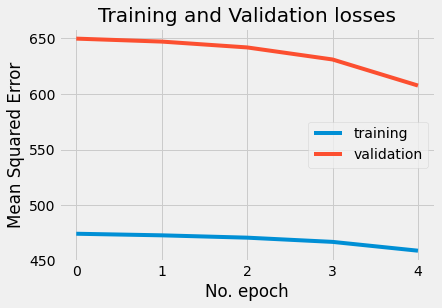

Model loss 459.046; Val loss 607.551
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 474.0836 - val_loss: 650.5219
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 474.0287 - val_loss: 650.4783
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 473.9935 - val_loss: 650.4454
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 473.9637 - val_loss: 650.4169
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 473.9374 - val_loss: 650.3911


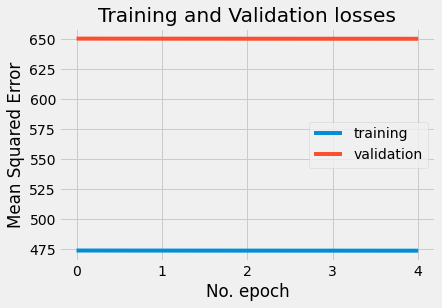

Model loss 473.937; Val loss 650.391
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 474.0444 - val_loss: 650.2155
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 473.9165 - val_loss: 650.0956
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 473.8099 - val_loss: 649.9856
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 473.7127 - val_loss: 649.8802
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 473.6192 - val_loss: 649.7783


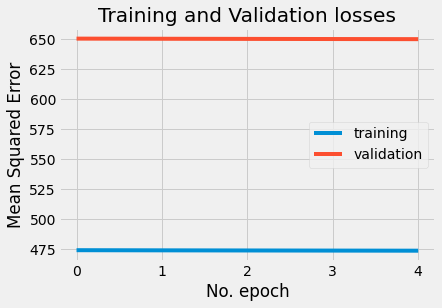

Model loss 473.619; Val loss 649.778
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 474.6899 - val_loss: 651.0646
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 474.5922 - val_loss: 650.9775
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 474.5139 - val_loss: 650.8998
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 474.4382 - val_loss: 650.8254
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 474.3622 - val_loss: 650.7525


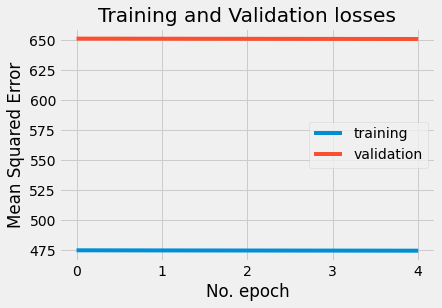

Model loss 474.362; Val loss 650.753
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 276.0173 - val_loss: 317.4536
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 208.9209 - val_loss: 320.5764
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 198.9712 - val_loss: 317.5639
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 192.9458 - val_loss: 302.0954
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 186.2230 - val_loss: 302.4102


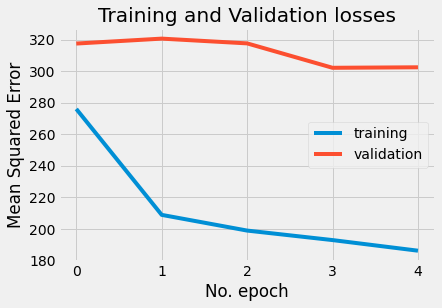

Model loss 186.223; Val loss 302.41
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 275.7640 - val_loss: 337.5544
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 205.5742 - val_loss: 316.0305
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 197.7211 - val_loss: 304.0049
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 191.6480 - val_loss: 301.7589
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 185.7840 - val_loss: 288.4901


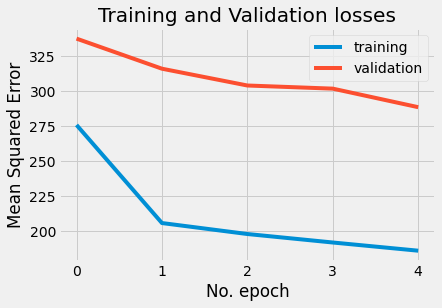

Model loss 185.784; Val loss 288.49
None
Epoch 1/5
245/245 [==============================] - 6s 17ms/step - loss: 255.6112 - val_loss: 333.8814
Epoch 2/5
245/245 [==============================] - 4s 16ms/step - loss: 196.6281 - val_loss: 324.4056
Epoch 3/5
245/245 [==============================] - 4s 16ms/step - loss: 190.6349 - val_loss: 314.3216
Epoch 4/5
245/245 [==============================] - 4s 16ms/step - loss: 183.9017 - val_loss: 292.9364
Epoch 5/5
245/245 [==============================] - 4s 16ms/step - loss: 181.4743 - val_loss: 280.0210


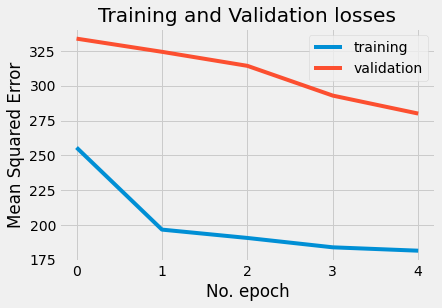

Model loss 181.474; Val loss 280.021
None


(0.0001, 0.005)

In [30]:
model_config = {"n_epochs": 5, "dropout": 0.4, "stateful": False}
output_dim = len(YCOLS)
batch_size=data_config["batch_size"]
epochs = model_config["n_epochs"]
learning_rate = [1e-4, 1e-5, 1e-6, 5*1e-4]
regularization = [1e-4, 1e-3, 5*1e-3]


        
hyp_tuning(model_config, data_config, output_dim, train_ds, val_ds, batch_size, epochs,learning_rate, regularization)

In [31]:
# results = (0.0005, 0.005)

In [32]:
from keras.models import load_model
model = load_model("model.h5")

In [38]:
dat = timeseries_dataset_from_df(test, data_config["batch_size"])

In [42]:
dat

AttributeError: 'ConcatenateDataset' object has no attribute 'shape'

In [35]:
x = model.predict(dat)

In [36]:
y = x.argmax()

In [37]:
x[y]

array([-15.034751, -15.132664], dtype=float32)